# __Camino de Santiago__ 
## Pilgrimage Data Retrieveal from the Cathedral RESTful Server 
### __Purpose:__ To extract data for storage in Excel and CSV files for analysis
#### *Notebook uses __serial async calls__ to avoid DoS defensive timeouts by the Server when concurrent gets are issued*

#### __Step 1:__ Load libraries

In [4]:

import time            ### To work with time objects
import json            ### To Process returned JSON data
import pandas as pd    ### To work with dataframes
import asyncio         ### To make async request
import httpx           ### To make request to Cathedral URL
import datetime        ### To work with datetime
import openpyxl        ### To save to Excel files


#### __Step 2:__ Initialize Panda dataframes to be filled

In [7]:
############## Dataframes to fill
 
tablelist = [
    'Anho',
    'Mes',
    'Identificador',
    'TotalRegistros',
    'Autonomias',
    'Caminos',
    'Continentes',
    'Edades',
    'Grupos',
    'Medios',
    'Motivos',
    'Paises',
    'Procedencias',
    'Sexos'
]
totals_df = pd.DataFrame(
    columns=['Anho', 'Mes', 'Identificador', 'TotalRegistros'])
autonomous_coms_df = pd.DataFrame(
    columns=['id', 'Anho', 'Mes', 'Nombre', 'Total', 'Porcentaje'])
routes_df = pd.DataFrame(
    columns=['id', 'Anho', 'Mes', 'Nombre', 'Total', 'Porcentaje'])
continents_df = pd.DataFrame(
    columns=['id', 'Anho', 'Mes', 'Nombre', 'Total', 'Porcentaje'])
ages_df = pd.DataFrame(
    columns=['id', 'Anho', 'Mes', 'Nombre', 'Total', 'Porcentaje'])
groups_df = pd.DataFrame(
    columns=['id', 'Anho', 'Mes', 'Nombre', 'Total', 'Porcentaje'])
transportation_df = pd.DataFrame(
    columns=['id', 'Anho', 'Mes', 'Nombre', 'Total', 'Porcentaje'])
motives_df = pd.DataFrame(
    columns=['id', 'Anho', 'Mes', 'Nombre', 'Total', 'Porcentaje'])
countries_df = pd.DataFrame(
    columns=['id', 'Anho', 'Mes', 'Nombre', 'Total', 'Porcentaje'])
origin_df = pd.DataFrame(
    columns=['id', 'Anho', 'Mes', 'Nombre', 'Total', 'Porcentaje'])
gender_df = pd.DataFrame(
    columns=['id', 'Anho', 'Mes', 'Nombre', 'Total', 'Porcentaje'])


#### __Step 3:__ Define functions that calculate the valid range of dates that may be retrieved from the server

In [9]:
############# Function that calculates the range of valid months
def range_of_months(start_date, end_date):
    months = []

    for i in range(start_date.year * 12 + start_date.month, end_date.year*12+end_date.month):
        #months.append(datetime.date((i-13) // 12 + 1, (i-1) % 12 + 1, 1))
        date_iter = datetime.date((i-13) // 12 + 1, (i-1) % 12 + 1, 1)
        year = date_iter.year
        month = date_iter.month
        months.append([year, month])
    return months


data_start_date = datetime.date(2004, 1, 1) #start date is January 2004
data_end_date = datetime.datetime.now()  # datetime.date(2011, 2, 1)
year_months = []
year_months = range_of_months(data_start_date, data_end_date)
#print(year_months)

#### __Step 4:__ Define functions that concatenate newly retrieved data to previously retrieved data

In [10]:
def add_prefix(idx, yr, mnth, df):
    df.insert(0, "id", idx)
    df.insert(1, "Anho", yr)
    df.insert(2, "Mes", mnth)
    return df


def add_to_dataframe(df_running_totals, yr, mnth, df_to_add):
    #print('dataframe1:',df1)
    #print('dataframe2:', df2)
    idx = str(yr)+str(mnth).zfill(2)
    add_prefix(idx, yr, mnth, df_to_add)
    frames = [df_running_totals, df_to_add]
    tempdf = pd.concat(frames, ignore_index=True)
    #print('temp',tempdf)

    return tempdf




#### __Step 5:__ Defines function that splits and converts retrieved json data to various the dataframes

In [12]:
############# Async function that requests data from the Cathedral's server ################
############# waits for response from server before it continues with requests to avoid empty responses (a "denial of service" defense mechanism? )


async def get_data(mes, anho):
    eMes = str(mes)
    eAnho = str(anho)
    url = 'https://catedral.df-server.info/ws/wsCatedral.asmx/ObtenerEstadisticasMes?eAnho=' + eAnho + '&eMes=' + eMes
    # print("mes:",mes,"anho:",anho,"url:",url)
    client = httpx.AsyncClient()
    async with client.stream('GET', url) as response:
        async for chunk in response.aiter_text():
           # print("Chunk:",chunk)
            if len(chunk) > 0:
                json_data_chunk = json.loads(chunk)
                totals_row = [anho, mes, json_data_chunk['Identificador'],json_data_chunk['TotalRegistros']]
                global totals_df
                totals_df.loc[len(totals_df.index)] = totals_row

                # Concatenate new results and running total dataframes, split JSON by key
                global autonomous_coms_df
                autonomous_coms_df=add_to_dataframe(autonomous_coms_df, anho, mes, pd.DataFrame(json_data_chunk['Autonomias']))
                global routes_df
                routes_df=add_to_dataframe(routes_df, anho, mes, pd.DataFrame(json_data_chunk['Caminos']))
                global continents_df
                continents_df=add_to_dataframe(continents_df, anho, mes, pd.DataFrame(json_data_chunk['Continentes']))
                global ages_df
                ages_df=add_to_dataframe(ages_df, anho, mes, pd.DataFrame(json_data_chunk['Edades']))
                global groups_df
                groups_df=add_to_dataframe(groups_df, anho, mes, pd.DataFrame(json_data_chunk['Grupos']))
                global transportation_df
                transportation_df=add_to_dataframe(transportation_df, anho, mes, pd.DataFrame(json_data_chunk['Medios']))
                global motives_df
                motives_df=add_to_dataframe(motives_df, anho, mes, pd.DataFrame(json_data_chunk['Motivos']))
                global countries_df
                countries_df=add_to_dataframe(countries_df, anho, mes, pd.DataFrame(json_data_chunk['Paises']))
                global origin_df
                origin_df=add_to_dataframe(origin_df, anho, mes, pd.DataFrame(json_data_chunk['Procedencias']))
                global gender_df
                gender_df=add_to_dataframe(gender_df, anho, mes, pd.DataFrame(json_data_chunk['Sexos']))

                print('Mes:', eMes, 'Anho:', eAnho)
                #print("start:", json_data_chunk, ":end", len(chunk))
            else:
                break
    #async with httpx.AsyncClient() as client:
    #    response = await client.stream('GET',url)
    #    print(response)

    ######### TEST ###############
    """ 
    for yAnho in range(2004,2005):
        for xMes in range(1,12):
            await get_data(xMes,yAnho)
    """    
    ######### TEST END ###########  


data_start_date = datetime.date(2004, 1, 1)
#data_end_date = datetime.date(2004, 3, 1)
data_end_date = datetime.datetime.now()  # datetime.date(2011, 2, 1)
year_months = []
year_months = range_of_months(data_start_date, data_end_date)
#print(year_months)


for year_month in range(len(year_months)):
    await get_data(year_months[year_month][1],year_months[year_month][0])

  

Mes: 1 Anho: 2004
Mes: 2 Anho: 2004
Mes: 3 Anho: 2004
Mes: 4 Anho: 2004
Mes: 5 Anho: 2004
Mes: 6 Anho: 2004
Mes: 7 Anho: 2004
Mes: 8 Anho: 2004
Mes: 9 Anho: 2004
Mes: 10 Anho: 2004
Mes: 11 Anho: 2004
Mes: 12 Anho: 2004
Mes: 1 Anho: 2005
Mes: 2 Anho: 2005
Mes: 3 Anho: 2005
Mes: 4 Anho: 2005
Mes: 5 Anho: 2005
Mes: 6 Anho: 2005
Mes: 7 Anho: 2005
Mes: 8 Anho: 2005
Mes: 9 Anho: 2005
Mes: 10 Anho: 2005
Mes: 11 Anho: 2005
Mes: 12 Anho: 2005
Mes: 1 Anho: 2006
Mes: 2 Anho: 2006
Mes: 3 Anho: 2006
Mes: 4 Anho: 2006
Mes: 5 Anho: 2006
Mes: 6 Anho: 2006
Mes: 7 Anho: 2006
Mes: 8 Anho: 2006
Mes: 9 Anho: 2006
Mes: 10 Anho: 2006
Mes: 11 Anho: 2006
Mes: 12 Anho: 2006
Mes: 1 Anho: 2007
Mes: 2 Anho: 2007
Mes: 3 Anho: 2007
Mes: 4 Anho: 2007
Mes: 5 Anho: 2007
Mes: 6 Anho: 2007
Mes: 7 Anho: 2007
Mes: 8 Anho: 2007
Mes: 9 Anho: 2007
Mes: 10 Anho: 2007
Mes: 11 Anho: 2007
Mes: 12 Anho: 2007
Mes: 1 Anho: 2008
Mes: 2 Anho: 2008
Mes: 3 Anho: 2008
Mes: 4 Anho: 2008
Mes: 5 Anho: 2008
Mes: 6 Anho: 2008
Mes: 7 Anho: 200

#### __Step 6:__ Rename columns to proper case

In [13]:
column_names = {
    "id": "ID",  "anho": "Anho", "mes": "Mes", "Nombre": "Descripcion", "Total": "Total",  "Porcentaje": "Porcentaje"}
autonomous_coms_df.rename(columns=column_names, inplace=True)

routes_df.rename(columns=column_names, inplace=True)
continents_df.rename(columns=column_names, inplace=True)
ages_df.rename(columns=column_names, inplace=True)
groups_df.rename(columns=column_names, inplace=True)
transportation_df.rename(columns=column_names, inplace=True)
motives_df.rename(columns=column_names, inplace=True)
countries_df.rename(columns=column_names, inplace=True)
origin_df.rename(columns=column_names, inplace=True)
gender_df.rename(columns=column_names, inplace=True)


#### __Step 7:__ Totals JSON from the server has an error, use genders to generate a true total using Pandas groupby with the sum() function

In [14]:
totals_true_df=gender_df.groupby(['ID','Anho','Mes'], as_index =False)['Total'].sum()


#### __Step 8:__ Create __"wide"__ tables from  __"long"__ data tables, in this step all nulls are converted to zero because these are numeric counts

In [15]:

autonomous_coms_df2=autonomous_coms_df.groupby(['ID','Anho','Mes','Descripcion'], as_index =False)['Total'].sum()
autonomous_coms_wide_df=pd.pivot(autonomous_coms_df2,index=['ID','Anho','Mes'],columns='Descripcion',values='Total')
cols = autonomous_coms_df['Descripcion'].unique()
autonomous_coms_wide_df=autonomous_coms_wide_df[cols]
autonomous_coms_wide_df.fillna(0,inplace=True)
autonomous_coms_wide_df['Total']=autonomous_coms_wide_df.sum(axis=1)
#autonomous_coms_wide_df

routes_df2=routes_df.groupby(['ID','Anho','Mes','Descripcion'], as_index =False)['Total'].sum()
routes_wide_df=pd.pivot(routes_df2,index=['ID','Anho','Mes'],columns='Descripcion',values='Total')
cols = routes_df['Descripcion'].unique()
routes_wide_df=routes_wide_df[cols]
routes_wide_df.fillna(0,inplace=True)
routes_wide_df['Total']=routes_wide_df.sum(axis=1)
#routes_wide_df

continents_df2=continents_df.groupby(['ID','Anho','Mes','Descripcion'], as_index =False)['Total'].sum()
continents_wide_df=pd.pivot(continents_df2,index=['ID','Anho','Mes'],columns='Descripcion',values='Total')
cols = continents_df['Descripcion'].unique()
continents_wide_df=continents_wide_df[cols]
continents_wide_df.fillna(0,inplace=True)
continents_wide_df['Total']=continents_wide_df.sum(axis=1)
#continents_wide_df

ages_df2=ages_df.groupby(['ID','Anho','Mes','Descripcion'], as_index =False)['Total'].sum()
ages_wide_df=pd.pivot(ages_df2,index=['ID','Anho','Mes'],columns='Descripcion',values='Total')
cols = ages_df['Descripcion'].unique()
ages_wide_df=ages_wide_df[cols]
ages_wide_df.fillna(0,inplace=True)
ages_wide_df['Total']=ages_wide_df.sum(axis=1)
#ages_wide_df

groups_df2=groups_df.groupby(['ID','Anho','Mes','Descripcion'], as_index =False)['Total'].sum()
groups_wide_df=pd.pivot(groups_df2,index=['ID','Anho','Mes'],columns='Descripcion',values='Total')
cols = groups_df['Descripcion'].unique()
groups_wide_df=groups_wide_df[cols]
groups_wide_df.fillna(0,inplace=True)
groups_wide_df['Total']=groups_wide_df.sum(axis=1)
#groups_wide_df

transportation_df2=transportation_df.groupby(['ID','Anho','Mes','Descripcion'], as_index =False)['Total'].sum()
transportation_wide_df=pd.pivot(transportation_df2,index=['ID','Anho','Mes'],columns='Descripcion',values='Total')
cols = transportation_df['Descripcion'].unique()
transportation_wide_df=transportation_wide_df[cols]
transportation_wide_df.fillna(0,inplace=True)
transportation_wide_df['Total']=transportation_wide_df.sum(axis=1)
#transportation_wide_df

motives_df2=motives_df.groupby(['ID','Anho','Mes','Descripcion'], as_index =False)['Total'].sum()
motives_wide_df=pd.pivot(motives_df2,index=['ID','Anho','Mes'],columns='Descripcion',values='Total')
cols = motives_df['Descripcion'].unique()
motives_wide_df=motives_wide_df[cols]
motives_wide_df.fillna(0,inplace=True)
motives_wide_df['Total']=motives_wide_df.sum(axis=1)
#motives_wide_df

countries_df2=countries_df.groupby(['ID','Anho','Mes','Descripcion'], as_index =False)['Total'].sum()
countries_wide_df=pd.pivot(countries_df2,index=['ID','Anho','Mes'],columns='Descripcion',values='Total')
cols = countries_df['Descripcion'].unique()
countries_wide_df=countries_wide_df[cols]
countries_wide_df.fillna(0,inplace=True)
countries_wide_df['Total']=countries_wide_df.sum(axis=1)
#countries_wide_df

origin_df2=origin_df.groupby(['ID','Anho','Mes','Descripcion'], as_index =False)['Total'].sum()
origin_wide_df=pd.pivot(origin_df2,index=['ID','Anho','Mes'],columns='Descripcion',values='Total')
cols = origin_df['Descripcion'].unique()
origin_wide_df=origin_wide_df[cols]
origin_wide_df.fillna(0,inplace=True)
origin_wide_df['Total']=origin_wide_df.sum(axis=1)
#origin_wide_df

gender_df2=gender_df.groupby(['ID','Anho','Mes','Descripcion'], as_index =False)['Total'].sum()
gender_wide_df=pd.pivot(gender_df2,index=['ID','Anho','Mes'],columns='Descripcion',values='Total')
cols = gender_df['Descripcion'].unique()
gender_wide_df=gender_wide_df[cols]
gender_wide_df.fillna(0,inplace=True)
gender_wide_df['Total']=gender_wide_df.sum(axis=1)
gender_wide_df 


,,Descripcion,Hombre,Mujer,Desconocido,Sin establecer,Total
ID,Anho,Mes,,,,,
200401,2004,1,908.0,378.0,0.0,0.0,1286.0
200402,2004,2,1820.0,982.0,0.0,0.0,2802.0
200403,2004,3,3676.0,2534.0,0.0,0.0,6210.0
200404,2004,4,16874.0,14234.0,0.0,0.0,31108.0
200405,2004,5,19556.0,14164.0,0.0,0.0,33720.0
...,...,...,...,...,...,...,...
202208,2022,8,40301.0,45541.0,0.0,0.0,85842.0
202209,2022,9,30514.0,35681.0,0.0,1.0,66196.0
202210,2022,10,24511.0,26845.0,0.0,0.0,51356.0


#### __Step 8:__ Output Excel files

In [16]:
### Path to use to save the dataframes to Excel files  ###
save_path_xl="C:/Sites/CaminoAwait/Data/Excel_Wide/"

totals_df.to_excel(save_path_xl+"camino_totals_wide.xlsx", engine="openpyxl")
autonomous_coms_wide_df.to_excel(save_path_xl+"camino_autonomous_comm_wide.xlsx", engine="openpyxl")
routes_wide_df.to_excel(save_path_xl+"camino_routes_wide.xlsx", engine="openpyxl")
continents_wide_df.to_excel(save_path_xl+"camino_continents_wide.xlsx", engine="openpyxl")
ages_wide_df.to_excel(save_path_xl+"camino_ages_wide.xlsx", engine="openpyxl")
groups_wide_df.to_excel(save_path_xl+"camino_groups_wide.xlsx", engine="openpyxl")
transportation_wide_df.to_excel(save_path_xl+"camino_transportation_wide.xlsx", engine="openpyxl")
motives_wide_df.to_excel(save_path_xl+"camino_motives_wide.xlsx", engine="openpyxl")
countries_wide_df.to_excel(save_path_xl+"camino_countries_wide.xlsx", engine="openpyxl")
origin_wide_df.to_excel(save_path_xl+"camino_origin_wide.xlsx", engine="openpyxl")
gender_wide_df.to_excel(save_path_xl+"camino_gender_wide.xlsx", engine="openpyxl")
totals_true_df.to_excel(save_path_xl+"camino_totals_true_wide.xlsx", engine="openpyxl")

### Path to use to save the dataframes to Excel files as Long Data ###
save_path_xl_long="C:/Sites/CaminoAwait/Data/Excel_Long/"

totals_df.to_excel(save_path_xl_long+"camino_totals_long.xlsx", engine="openpyxl")
autonomous_coms_df2.to_excel(save_path_xl_long+"camino_autonomous_comm_long.xlsx", engine="openpyxl")
routes_df2.to_excel(save_path_xl_long+"camino_routes_long.xlsx", engine="openpyxl")
continents_df2.to_excel(save_path_xl_long+"camino_continents_long.xlsx", engine="openpyxl")
ages_df2.to_excel(save_path_xl_long+"camino_ages_long.xlsx", engine="openpyxl")
groups_df2.to_excel(save_path_xl_long+"camino_groups_long.xlsx", engine="openpyxl")
transportation_df2.to_excel(save_path_xl_long+"camino_transportation_long.xlsx", engine="openpyxl")
motives_df2.to_excel(save_path_xl_long+"camino_motives_long.xlsx", engine="openpyxl")
countries_df2.to_excel(save_path_xl_long+"camino_countries_long.xlsx", engine="openpyxl")
origin_df2.to_excel(save_path_xl_long+"camino_origin_long.xlsx", engine="openpyxl")
gender_df2.to_excel(save_path_xl_long+"camino_gender_long.xlsx", engine="openpyxl")
totals_true_df.to_excel(save_path_xl_long+"camino_totals_true_long.xlsx", engine="openpyxl")

#### __Step 9:__ Output CSV files

In [17]:
### Path to use to save the dataframes to CSV files  ###
save_path_csv="C:/Sites/CaminoAwait/Data/CSV_Wide/"


totals_df.to_csv(save_path_csv+"camino_totals_wide.csv",  header=True, index=True)
autonomous_coms_wide_df.to_csv(save_path_csv+"camino_autonomous_comm_wide.csv",  header=True, index=True)
routes_wide_df.to_csv(save_path_csv+"camino_routes_wide.csv",  header=True, index=True)
continents_wide_df.to_csv(save_path_csv+"camino_continents_wide.csv",  header=True, index=True)
ages_wide_df.to_csv(save_path_csv+"camino_ages_wide.csv",  header=True, index=True)
groups_wide_df.to_csv(save_path_csv+"camino_groups_wide.csv",  header=True, index=True)
transportation_wide_df.to_csv(save_path_csv+"camino_transportation_wide.csv",  header=True, index=True)
motives_wide_df.to_csv(save_path_csv+"camino_motives_wide.csv",  header=True, index=True)
countries_wide_df.to_csv(save_path_csv+"camino_countries_wide.csv",  header=True, index=True)
origin_wide_df.to_csv(save_path_csv+"camino_origin_wide.csv",  header=True, index=True)
gender_wide_df.to_csv(save_path_csv+"camino_gender_wide.csv",  header=True, index=True)
totals_true_df.to_csv(save_path_csv+"camino_totals_true_wide.csv",  header=True, index=True)

### Path to use to save the dataframes to CSV files as Long Data ###
save_path_csv_long="C:/Sites/CaminoAwait/Data/CSV_Long/"

totals_df.to_csv(save_path_csv_long+"camino_totals_long.csv",  header=True, index=True)
autonomous_coms_df2.to_csv(save_path_csv_long+"camino_autonomous_comm_long.csv",  header=True, index=True)
routes_df2.to_csv(save_path_csv_long+"camino_routes_long.csv",  header=True, index=True)
continents_df2.to_csv(save_path_csv_long+"camino_continents_long.csv",  header=True, index=True)
ages_df2.to_csv(save_path_csv_long+"camino_ages_long.csv",  header=True, index=True)
groups_df2.to_csv(save_path_csv_long+"camino_groups_long.csv",  header=True, index=True)
transportation_df2.to_csv(save_path_csv_long+"camino_transportation_long.csv",  header=True, index=True)
motives_df2.to_csv(save_path_csv_long+"camino_motives_long.csv",  header=True, index=True)
countries_df2.to_csv(save_path_csv_long+"camino_countries_long.csv",  header=True, index=True)
origin_df2.to_csv(save_path_csv_long+"camino_origin_long.csv",  header=True, index=True)
gender_df2.to_csv(save_path_csv_long+"camino_gender_long.csv",  header=True, index=True)
totals_true_df.to_csv(save_path_csv_long+"camino_totals_true_long.csv",  header=True, index=True)



### __Additional Tables:__ File with cumulative pilgrims per point of origin.
#### __Step 10:__ Load Additional library to model flow with a directed acyclical graph (DAG)

In [5]:
import networkx as nx


#### __Step 11:__ Read in Origins file in long format and route network

In [7]:
read_path_csv_long="C:/Sites/CaminoAwait/Data/CSV_Long/"
camino_origins=pd.read_csv(read_path_csv_long+"camino_origin_long.csv",  header=0,encoding="cp1252",dtype={'IDX':int,'Total':int})
camino_origins.rename(columns = {'Descripcion':'Origen'}, inplace = True)
read_path_csv_network="C:/Sites/"
camino_network=pd.read_csv(read_path_csv_network+"RoutesLatLng02.csv",  header=0,encoding="cp1252")



#### __Step 12:__ Read in Origins file in long format and route network

IDX: 0 Next: -1
IDX: 1 Next: 0
IDX: 2 Next: 26
IDX: 3 Next: 9
IDX: 4 Next: 0
IDX: 5 Next: 57
IDX: 6 Next: 27
IDX: 7 Next: 50
IDX: 8 Next: 2
IDX: 9 Next: 29
IDX: 10 Next: 40
IDX: 11 Next: 0
IDX: 12 Next: 0
IDX: 13 Next: 74
IDX: 14 Next: 0
IDX: 15 Next: 13
IDX: 16 Next: 25
IDX: 17 Next: 22
IDX: 18 Next: 0
IDX: 19 Next: 75
IDX: 20 Next: 3
IDX: 21 Next: 0
IDX: 22 Next: 11
IDX: 23 Next: 12
IDX: 24 Next: 68
IDX: 25 Next: 19
IDX: 26 Next: 0
IDX: 27 Next: 1
IDX: 28 Next: 49
IDX: 29 Next: 38
IDX: 30 Next: 66
IDX: 31 Next: 0
IDX: 32 Next: 73
IDX: 33 Next: 52
IDX: 34 Next: 41
IDX: 35 Next: 0
IDX: 36 Next: 30
IDX: 37 Next: 43
IDX: 38 Next: 45
IDX: 39 Next: 0
IDX: 40 Next: 21
IDX: 41 Next: 3
IDX: 42 Next: 7
IDX: 43 Next: 44
IDX: 44 Next: 14
IDX: 45 Next: 54
IDX: 46 Next: 3
IDX: 47 Next: 61
IDX: 48 Next: 25
IDX: 49 Next: 25
IDX: 50 Next: 23
IDX: 51 Next: 0
IDX: 52 Next: 45
IDX: 53 Next: 0
IDX: 54 Next: 30
IDX: 55 Next: 51
IDX: 56 Next: 55
IDX: 57 Next: 8
IDX: 58 Next: 73
IDX: 59 Next: 0
IDX: 60 Next

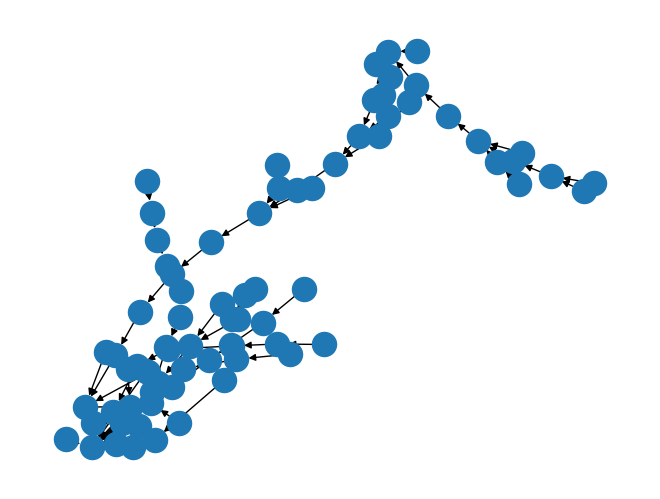

In [8]:
G_ex = nx.DiGraph()
G_ex.add_nodes_from([0],node_type="END",node_color="r")

for idx,row in camino_network.iterrows():
    ##print(row)
    ##print(camino_network[:nextid])
    print("IDX:",row["ID"],"Next:",row["NextID"])
    ##if row["NextID"]>=0: 
        
    if row["NextID"]>=0: 
        G_ex.add_nodes_from([row["ID"]],node_type="WAY",node_color="b")

for idx,row in camino_network.iterrows():
    ##print(row)
    ##print(camino_network[:nextid])
    ##if row["NextID"]>=0: print("IDX:",row["ID"],"Next:",row["NextID"])
    if row["NextID"]>=0: 
        G_ex.add_edges_from([(row["ID"],row["NextID"])])
    ##G_ex.add_nodes_from(row["ID"],node_type="WAY",node_color="b")   
nx.draw(G_ex)


#### __Step 13:__

In [9]:
[i for i in list(range(0,len(camino_network.index)))]
df_node_to_sum=pd.DataFrame()
ID_Node=[]
Node_Ancestors=[]
for i in list(range(0,len(camino_network.index))):
    ##print("i:",i,":",sorted(nx.ancestors(G_ex,i)|{i}))
    ID_Node.append(i)
    Node_Ancestors.append(sorted(nx.ancestors(G_ex,i)|{i}))

df_node_to_sum=pd.DataFrame(list(zip(ID_Node,Node_Ancestors)),columns=['ID_Node','Node_Ancestors'])
##print(len(ID_Node))
##print(len(Node_Ancestors))

#### __Step 14:__

In [10]:
dflookup=camino_network[['Origen','ID']].copy()
print(dflookup)
camino_origins2=camino_origins.merge(right=dflookup,left_on="Origen",right_on="Origen",suffixes=('','_Node'))
camino_origins2=camino_origins2.sort_values(by=["IDX"])

camino_origins2=camino_origins.merge(how="left",right=dflookup,left_on="Origen",right_on="Origen",suffixes=('','_Node'))

                             Origen  ID
0   Catedral Santiago de Compostela   0
1                            Sarria   1
2                               Tui   2
3                   S. Jean P. Port   3
4                            Ferrol   4
..                              ...  ..
71                 Vega de Valcarce  71
72                            Verín  72
73                          Vezelay  73
74                 Viana do Castelo  74
75                       Vilafranca  75

[76 rows x 2 columns]


#### __Step 15:__

In [11]:
pilgrim_sum_node_yr_month=[]
for node_idx in list(range(0,len(camino_origins2))):
    #print("node_yr:",camino_origins2.iloc[node_idx]["Anho"]," node_month:",camino_origins2.iloc[node_idx]["Mes"]," ID_Node:",camino_origins2.iloc[node_idx]["ID_Node"])
    ##print("node_idx:",node_idx," ID_Node>:",df_node_to_sum.iloc[camino_origins2.iloc[node_idx]["ID_Node"]]," Ancestors>:",df_node_to_sum.iloc[camino_origins2.iloc[node_idx]["ID_Node"]]["Node_Ancestors"])
    
    ##print("node_idx:",node_idx," ID_Node:",int(camino_origins2.iloc[node_idx]["ID_Node"]))
    ##print("node_idx:",node_idx,"node_yr:",camino_origins2.iloc[node_idx]["Anho"]," node_month:",camino_origins2.iloc[node_idx]["Mes"]," ID_Node:",camino_origins2.iloc[node_idx]["ID_Node"]," Ancestors>:",df_node_to_sum.iloc[int(camino_origins2.iloc[node_idx]["ID_Node"])]["Node_Ancestors"])
    
    ##print
    pilgrim_sum_node_yr_month.append(
    camino_origins2[
    (camino_origins2["Anho"]==camino_origins2.iloc[node_idx]["Anho"])&
    (camino_origins2["Mes"]== camino_origins2.iloc[node_idx]["Mes"] )&
    (camino_origins2["ID_Node"].isin(df_node_to_sum.iloc[camino_origins2.iloc[node_idx]["ID_Node"]]["Node_Ancestors"]))
    ]["Total"].sum()
    )

#### __Step 16:__

In [12]:
def make_proto(camino_network_in):
    proto_camino_network_out=camino_network_in[['ID','Origen']].copy()
    proto_camino_network_out.rename(columns={'ID':'ID_Node'},inplace=True)
    return proto_camino_network_out

#num_to_repeat=pd.unique(camino_origins['ID'])

proto_camino_network=make_proto(camino_network)
print("proto:",proto_camino_network)

num_to_repeat=len(camino_network)
print("num_to_repeat:",num_to_repeat)
camino_origins_all=pd.DataFrame()

for i in pd.unique(camino_origins['ID']):
    print(int(str(i)[0:4])," ",int(str(i)[4:]))
    list_years=[int(str(i)[0:4])]*num_to_repeat
    list_mnths=[int(str(i)[4:])]*num_to_repeat
    temp_camino_network=proto_camino_network.copy()
    #temp_camino_network.rename(columns={'ID':'ID_Node'},inplace=True)
    temp_camino_network["ID"]=i
    temp_camino_network["Anho"]=list_years
    temp_camino_network["Mes"]=list_mnths
    
    
    temp_camino_network=pd.merge(temp_camino_network,camino_origins[["ID","Origen","Total"]],how="left",left_on=["ID","Origen"],right_on=["ID","Origen"],suffixes=["","_drop"])
    temp_camino_network["Total"]=temp_camino_network["Total"].fillna(0)


    pilgrim_sum_node_yr_month=[]
    for node_idx in list(range(0,len(temp_camino_network))):
    
        pilgrim_sum_node_yr_month.append(
        temp_camino_network[
        (temp_camino_network["Anho"]==temp_camino_network.iloc[node_idx]["Anho"])&
        (temp_camino_network["Mes"]== temp_camino_network.iloc[node_idx]["Mes"] )&
        (temp_camino_network["ID_Node"].isin(df_node_to_sum.iloc[temp_camino_network.iloc[node_idx]["ID_Node"]]["Node_Ancestors"]))
        ]["Total"].sum()
        )
    temp_camino_network["Total_Origen_Incoming"]=pilgrim_sum_node_yr_month-temp_camino_network["Total"]
    temp_camino_network["Total_Origin_Cumulative"]=pilgrim_sum_node_yr_month

    print("Temp") 
    print(temp_camino_network)
    #print(temp_camino_network)
    camino_origins_all=pd.concat([camino_origins_all,temp_camino_network],axis=0)
camino_origins_all

proto:     ID_Node                           Origen
0         0  Catedral Santiago de Compostela
1         1                           Sarria
2         2                              Tui
3         3                  S. Jean P. Port
4         4                           Ferrol
..      ...                              ...
71       71                 Vega de Valcarce
72       72                            Verín
73       73                          Vezelay
74       74                 Viana do Castelo
75       75                       Vilafranca

[76 rows x 2 columns]
num_to_repeat: 76
2004   1
Temp
    ID_Node                           Origen      ID  Anho  Mes  Total  \
0         0  Catedral Santiago de Compostela  200401  2004    1    0.0   
1         1                           Sarria  200401  2004    1  304.0   
2         2                              Tui  200401  2004    1    0.0   
3         3                  S. Jean P. Port  200401  2004    1   60.0   
4         4                 

,ID_Node,Origen,ID,Anho,Mes,Total,Total_Origen_Incoming,Total_Origin_Cumulative
0,0,Catedral Santiago de Compostela,200401,2004,1,0.0,1286.0,1286.0
1,1,Sarria,200401,2004,1,304.0,734.0,1038.0
2,2,Tui,200401,2004,1,0.0,0.0,0.0
3,3,S. Jean P. Port,200401,2004,1,60.0,0.0,60.0
4,4,Ferrol,200401,2004,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
71,71,Vega de Valcarce,202212,2022,12,0.0,625.0,625.0
72,72,Verín,202212,2022,12,0.0,0.0,0.0
73,73,Vezelay,202212,2022,12,0.0,0.0,0.0
74,74,Viana do Castelo,202212,2022,12,0.0,142.0,142.0


#### __Step 17:__

In [13]:
save_path_csv_long="C:/Sites/CaminoAwait/Data/CSV_Long/"
camino_origins_all.to_csv(save_path_csv_long+"camino_origins_cumulative_long_new.csv",  header=True, index=False)

#### __END__